<a href="https://colab.research.google.com/github/HersheyZinc/Screw_classifier/blob/main/Model_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data preprocessing**

## Import data and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

import os
import numpy as np


TRAIN_TEST_DIR="/content/gdrive/MyDrive/Colab Notebooks/DEEP/train-test"
VAL_DIR = "/content/gdrive/MyDrive/Colab Notebooks/DEEP/validation"
IMG_WIDTH = 256
IMG_HEIGHT = 256
batch_size=64


types = ["M6_12","M6_10", "M4_10","M4_16"]
types = os.listdir(TRAIN_TEST_DIR)

In [ ]:
total = 0
for name in types:
  img_count = len(os.listdir(os.path.join(TRAIN_TEST_DIR,name)))
  total+=img_count
  print("{} images: {}".format(name, img_count))

print("Total images found: {}".format(total))

M6_12 images: 573
M6_10 images: 510
M4_10 images: 458
M4_16 images: 510
None images: 480
Total images found: 2531


## Image Generators

For the train dataset, I utilized data augmentation to improve the variety of images:
1. rotation range - rotates the images
2. horizontal flip - flips the images
3. brightness range - alters the overall brightness to be slightly darker or brighter

In [ ]:
#Create Image generators for train and test datasets
split = 0.2

image_generator = ImageDataGenerator(rescale=1./255,rotation_range=15,horizontal_flip=True,brightness_range=(0.7,1.2),validation_split=split) 
train_data_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                      directory=TRAIN_TEST_DIR,
                                                      shuffle=True,
                                                      target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                      class_mode='categorical',subset="training")

test_data_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=TRAIN_TEST_DIR,
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                              class_mode='categorical',subset="validation")

train_size, test_size = train_data_gen.samples, test_data_gen.samples

Found 2029 images belonging to 5 classes.
Found 505 images belonging to 5 classes.


In [ ]:
val_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(VAL_DIR, batch_size=24,target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                           class_mode='categorical')

Found 48 images belonging to 5 classes.


In [ ]:
labels = (train_data_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
def getType(arr):
  for i in range(len(arr)):
    if arr[i] == 1:
      return labels[i]

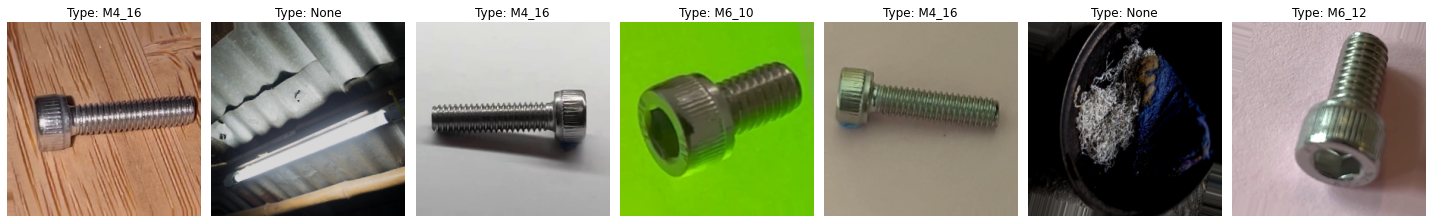

In [ ]:
#Check 7 random images from train image generator
sample_training_images, category = next(train_data_gen)
images_arr = sample_training_images[:7]

fig, axes = plt.subplots(1, 7, figsize=(20,20))
axes = axes.flatten()
for img, ax, act in zip( images_arr, axes, category[:7]):
    ax.imshow(img)
    ax.axis('off')
    ax.title.set_text("Type: {}".format(getType(act)))
plt.tight_layout()
plt.show()

## Evaluation functions

In [ ]:
def validation_report(generator, model):
  images_arr, actual = next(generator)[:25]
  predictions = model.predict(images_arr).argmax(axis=1)
  correct = 0

  fig, axes = plt.subplots(2, 12, figsize=(20,5))
  axes = axes.flatten()
  for img, ax, pred, act in zip(images_arr, axes, predictions, actual):
      ax.imshow(img)
      ax.axis('off')
      ax.title.set_text("Pred: {}\nActual: {}".format(labels[pred], getType(act)))
      if labels[pred] == getType(act):
        correct +=1
  plt.tight_layout()
  plt.show()
  print("Score: {}/{} correct".format(correct,24))

In [ ]:
def hist_report(hist):
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  epoch = range(len(loss))

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epoch,loss,label='loss')
  plt.plot(epoch,val_loss,label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epoch,acc,label='acc')
  plt.plot(epoch,val_acc,label='val_acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

# **Basic Model**

This is the first try at creating a CNN model to classify these screws. I used a very general and simple model and trained it over 10 epochs

## Train the model

In [ ]:
model = Sequential([
    Conv2D(3, 3, padding='same', activation='relu', input_shape = (IMG_HEIGHT, IMG_WIDTH,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs=15


history = model.fit(
    train_data_gen,
    steps_per_epoch=train_size//batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps= test_size//batch_size
)

Epoch 1/15
31/31 [==============================] - 121s 4s/step - loss: 8.2187 - accuracy: 0.2370 - val_loss: 2.1305 - val_accuracy: 0.1942
Epoch 2/15
31/31 [==============================] - 116s 4s/step - loss: 1.6614 - accuracy: 0.3293 - val_loss: 1.7235 - val_accuracy: 0.3214
Epoch 3/15
31/31 [==============================] - 118s 4s/step - loss: 1.4136 - accuracy: 0.4149 - val_loss: 1.6082 - val_accuracy: 0.3125
Epoch 4/15
31/31 [==============================] - 116s 4s/step - loss: 1.3790 - accuracy: 0.4322 - val_loss: 1.5224 - val_accuracy: 0.3393
Epoch 5/15
31/31 [==============================] - 115s 4s/step - loss: 1.4105 - accuracy: 0.4506 - val_loss: 1.5274 - val_accuracy: 0.3616
Epoch 6/15
31/31 [==============================] - 114s 4s/step - loss: 1.2131 - accuracy: 0.5082 - val_loss: 1.4666 - val_accuracy: 0.4040
Epoch 7/15
31/31 [==============================] - 115s 4s/step - loss: 1.1520 - accuracy: 0.5449 - val_loss: 1.4990 - val_accuracy: 0.3504
Epoch 8/15
31

# Evaluate the model

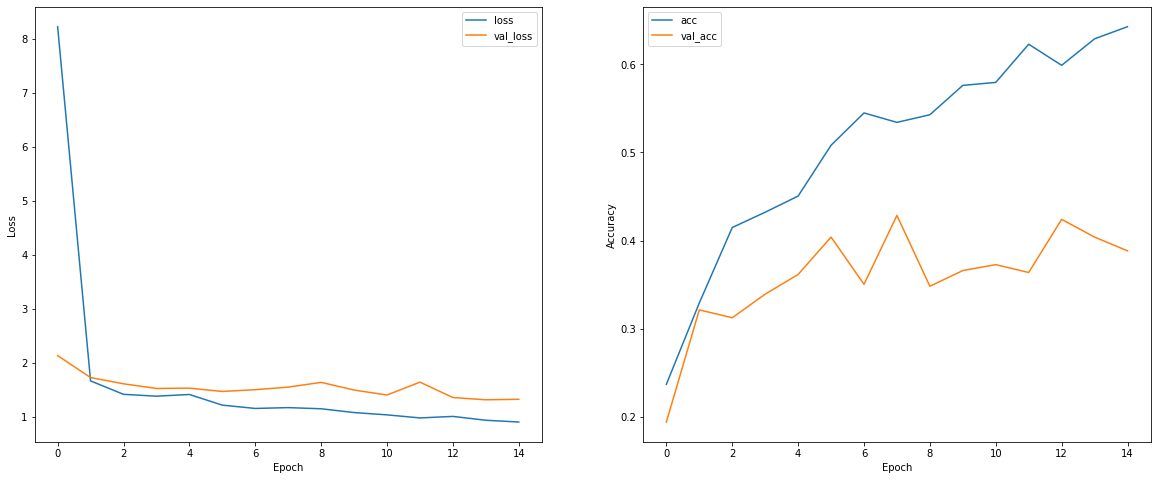

In [ ]:
hist_report(history)

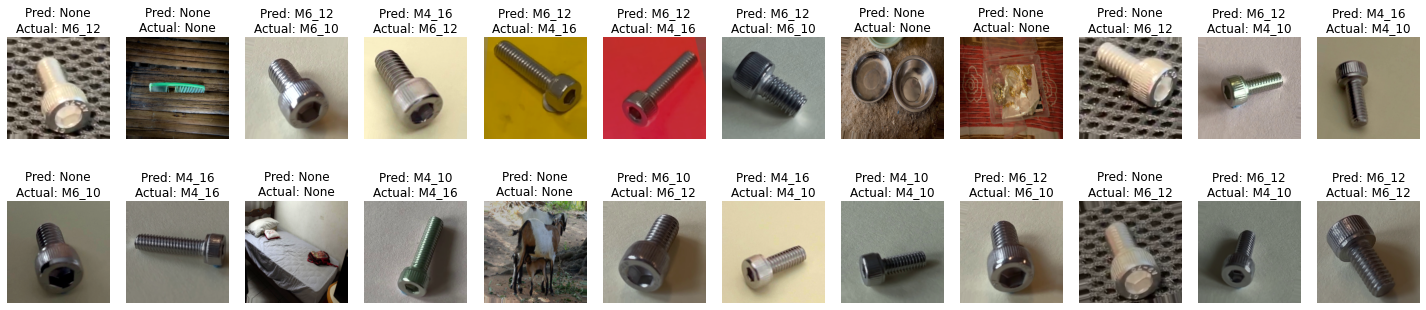

Score: 8/24 correct


In [ ]:
validation_report(test_data_gen,model)

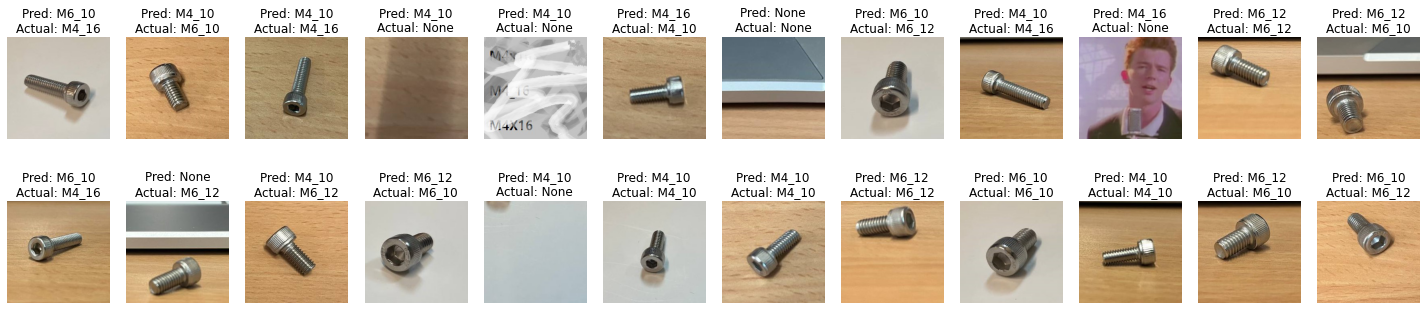

Score: 7/24 correct


In [ ]:
validation_report(val_data_gen,model)

## Observations

The train-test accuracy of this model was quite bad at roughly 50%.
It also did not fare well on the validation data set and scored 8/24

We can tune the layers more to hopefully obtain a better outcome

#**Model 2**

Here, we compile another model. This time we add another 2D convolution layer and remove the dropout

## Train the model

In [ ]:
model2 = Sequential([
    Conv2D(3, 3, padding='same', activation='relu', input_shape = (IMG_HEIGHT, IMG_WIDTH,3)),
    MaxPooling2D(),
    Conv2D(3, 6, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(5, 3, padding='same', activation='relu'),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 20
history2 = model2.fit(
    train_data_gen,
    steps_per_epoch=train_size//batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=test_size//batch_size
)

Epoch 1/20
31/31 [==============================] - 149s 5s/step - loss: 1.3476 - accuracy: 0.4139 - val_loss: 1.2975 - val_accuracy: 0.4754
Epoch 2/20
31/31 [==============================] - 145s 5s/step - loss: 1.1072 - accuracy: 0.5510 - val_loss: 1.2599 - val_accuracy: 0.6116
Epoch 3/20
31/31 [==============================] - 145s 5s/step - loss: 0.9533 - accuracy: 0.6407 - val_loss: 1.3428 - val_accuracy: 0.5513
Epoch 4/20
31/31 [==============================] - 143s 5s/step - loss: 0.8544 - accuracy: 0.6764 - val_loss: 1.3896 - val_accuracy: 0.6205
Epoch 5/20
31/31 [==============================] - 144s 5s/step - loss: 0.7418 - accuracy: 0.7197 - val_loss: 1.3264 - val_accuracy: 0.6652
Epoch 6/20
31/31 [==============================] - 143s 5s/step - loss: 0.6614 - accuracy: 0.7421 - val_loss: 1.4605 - val_accuracy: 0.6317
Epoch 7/20
31/31 [==============================] - 142s 5s/step - loss: 0.6124 - accuracy: 0.7630 - val_loss: 1.6192 - val_accuracy: 0.6339
Epoch 8/20
31

## Evaluate the model

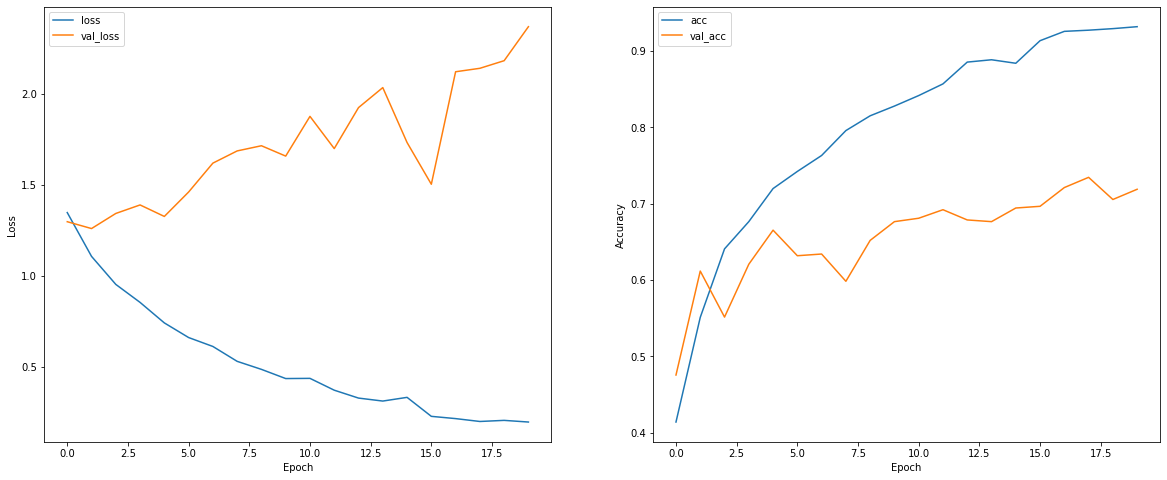

In [ ]:
hist_report(history2)

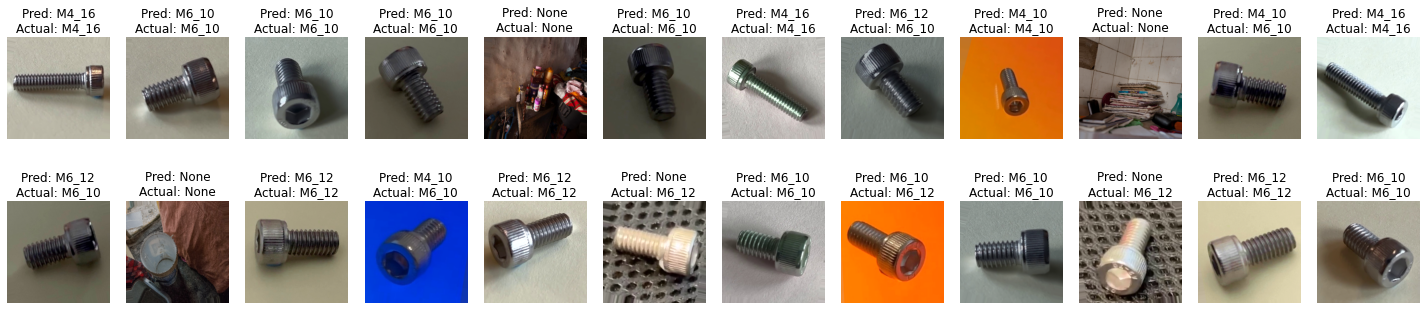

Score: 17/24 correct


In [ ]:
validation_report(test_data_gen,model2)

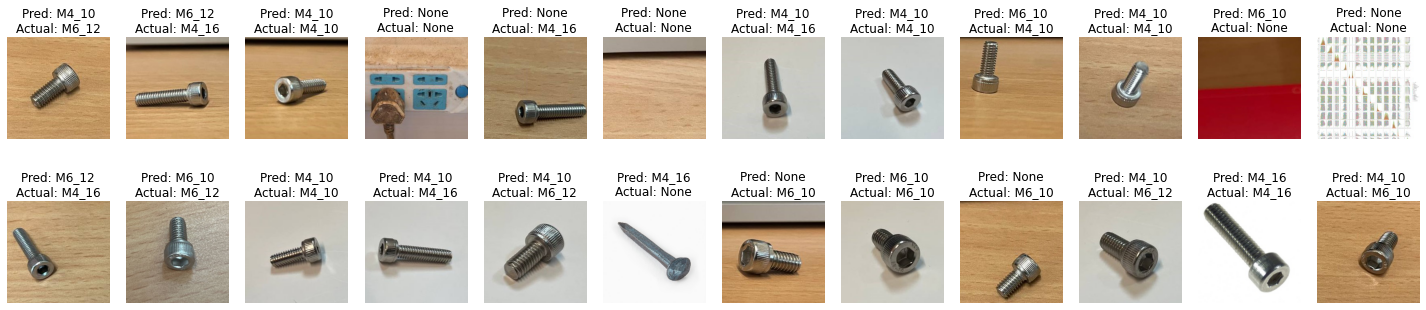

Score: 9/24 correct


In [ ]:
validation_report(val_data_gen,model2)

## Observation

The results of this model were surprisingly good, with ~85% train and test accuracy scores.

However, this model fared worse on the validation set thna before, scoring 6/24. This indicates that the model is overfitting and not generalizing the features. As such we have to continue the search for a better model